# Symptom Analyzer for Disease Prediction

This notebook provides an interactive system to predict possible diseases based on symptoms. 
It demonstrates the entire machine learning process from data preparation to model training and prediction.

## Features
- Interactive symptom analysis with multiple machine learning models
- Visible training process with detailed visualizations
- Comparison of different prediction approaches (Naive Bayes, Random Forest, Deep Learning)
- Detailed explanations of each step in the machine learning pipeline


## Setup and Imports
Import necessary libraries and set up the environment.

In [34]:
#!/usr/bin/env python3
"""
Simplified Disease Prediction from Symptoms
Interactive symptom analyzer for Jupyter Notebook with visible training process
"""

import pandas as pd
import numpy as np
import os
import re
import warnings

# Suppress tensorflow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Import visualization libraries with fallbacks
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
    # Set plot style
    plt.style.use('ggplot')
    sns.set(style='whitegrid')
    visualization_available = True
except ImportError:
    print("Warning: Matplotlib or Seaborn not available. Visualizations will be disabled.")
    visualization_available = False

# Optional imports for progress tracking
try:
    from tqdm import tqdm
    from IPython.display import display, clear_output
    ipython_available = True
except ImportError:
    tqdm = lambda x, **kwargs: x  # Fallback for tqdm
    ipython_available = False

# ML libraries
try:
    from sklearn.model_selection import train_test_split
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.naive_bayes import MultinomialNB
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
    from sklearn.preprocessing import LabelEncoder
    sklearn_available = True
except ImportError:
    print("Error: scikit-learn is required for this application.")
    sklearn_available = False

# Deep learning libraries
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Dropout
    from tensorflow.keras.utils import to_categorical
    tensorflow_available = True
except ImportError:
    print("TensorFlow not available. Deep learning model will be disabled.")
    tensorflow_available = False


## Text Preprocessing
Define stopwords and text preprocessing functions.

In [35]:
# Define English stopwords (simplified version)
STOPWORDS = {
    'a', 'an', 'the', 'and', 'but', 'or', 'if', 'because', 'as', 'until', 'while',
    'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through',
    'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in',
    'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here',
    'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
    'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so',
    'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now', 'i',
    'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours',
    'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers',
    'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves',
    'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are',
    'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does',
    'did', 'doing', 'would', 'could', 'should', 'ought', 'i\'m', 'you\'re', 'he\'s',
    'she\'s', 'it\'s', 'we\'re', 'they\'re', 'i\'ve', 'you\'ve', 'we\'ve', 'they\'ve',
    'i\'d', 'you\'d', 'he\'d', 'she\'d', 'we\'d', 'they\'d', 'i\'ll', 'you\'ll', 'he\'ll',
    'she\'ll', 'we\'ll', 'they\'ll', 'isn\'t', 'aren\'t', 'wasn\'t', 'weren\'t', 'hasn\'t',
    'haven\'t', 'hadn\'t', 'doesn\'t', 'don\'t', 'didn\'t', 'won\'t', 'wouldn\'t',
    'shan\'t', 'shouldn\'t', 'can\'t', 'cannot', 'couldn\'t', 'mustn\'t', 'let\'s',
    'that\'s', 'who\'s', 'what\'s', 'here\'s', 'there\'s', 'when\'s', 'where\'s', 'why\'s',
    'how\'s'
}

# Simple text preprocessing function
def preprocess_text(text):
    """Simplified text preprocessing without relying on NLTK"""
    # Convert to lowercase
    text = text.lower()
    
    # Replace punctuation with spaces
    text = re.sub(r'[^\w\s]', ' ', text)
    
    # Tokenize by splitting on whitespace
    tokens = text.split()
    
    # Remove stopwords
    tokens = [token for token in tokens if token not in STOPWORDS]
    
    # Join tokens back into a string
    processed_text = ' '.join(tokens)
    
    return processed_text


## Dataset Creation
Create a sample dataset of symptoms and diseases for training.

In [36]:
def create_sample_dataset():
    """Create and display sample dataset with progress bar"""
    print("Creating sample dataset...")
    os.makedirs('data', exist_ok=True)
    
    # Expanding dataset with multiple examples per disease to improve learning
    data = """Symptoms,Disease
fever headache cough,Common Cold
mild fever runny nose sore throat,Common Cold
cough congestion sneezing,Common Cold
headache sore throat mild fever,Common Cold
fatigue cough runny nose,Common Cold
high fever severe headache stiff neck light sensitivity,Meningitis
stiff neck fever vomiting confusion,Meningitis
headache fever stiff neck rash,Meningitis
light sensitivity headache fever neck pain,Meningitis
confusion fever stiff neck headache,Meningitis
chest pain shortness of breath sweating,Heart Attack
pain radiating to arm jaw neck,Heart Attack
chest pressure nausea cold sweat,Heart Attack
shortness of breath chest discomfort fatigue,Heart Attack
chest tightness dizziness anxiety,Heart Attack
fatigue weight loss night sweats cough,Tuberculosis
coughing blood chest pain fever,Tuberculosis
fatigue persistent cough weight loss,Tuberculosis
night sweats fever persistent cough,Tuberculosis
chest pain fatigue coughing blood,Tuberculosis
abdominal pain diarrhea nausea vomiting,Gastroenteritis
stomach cramps watery diarrhea,Gastroenteritis
nausea vomiting fever diarrhea,Gastroenteritis
abdominal pain fever vomiting,Gastroenteritis
diarrhea dehydration stomach pain,Gastroenteritis
high fever fatigue sore throat swollen lymph glands,Mononucleosis
swollen lymph nodes fatigue fever,Mononucleosis
extreme fatigue sore throat headache,Mononucleosis
fever swollen spleen fatigue,Mononucleosis
sore throat fever fatigue rash,Mononucleosis
fever rash joint pain muscle pain,Dengue
high fever headache pain behind eyes,Dengue
muscle joint pain rash vomiting,Dengue
fever rash fatigue bleeding gums,Dengue
severe headache pain behind eyes fever,Dengue
frequent urination excessive thirst hunger weight loss,Diabetes
increased thirst frequent urination fatigue,Diabetes
blurry vision slow healing wounds,Diabetes
weight loss extreme hunger fatigue,Diabetes
tingling hands feet excessive thirst,Diabetes
wheezing shortness of breath chest tightness coughing,Asthma
shortness of breath wheezing coughing,Asthma
chest tightness difficulty breathing wheezing,Asthma
coughing at night shortness of breath,Asthma
exercise induced breathing difficulty,Asthma"""
    
    with open('data/symptom_disease.csv', 'w') as f:
        f.write(data)
    
    print("✓ Sample dataset created successfully")
    return pd.read_csv('data/symptom_disease.csv')

## Data Visualization
Visualize the dataset to understand its distribution.

In [37]:
def visualize_dataset(df):
    """Display dataset statistics and visualizations"""
    print("\n=== Dataset Overview ===")
    print(f"Total samples: {len(df)}")
    print(f"Number of unique diseases: {df['Disease'].nunique()}")
    
    # Add processed symptoms column if not exists
    if 'Processed_Symptoms' not in df.columns:
        df['Processed_Symptoms'] = df['Symptoms'].apply(preprocess_text)
    
    # Disease distribution
    plt.figure(figsize=(12, 6))
    disease_counts = df['Disease'].value_counts()
    sns.barplot(x=disease_counts.values, y=disease_counts.index)
    plt.title('Distribution of Diseases in Dataset')
    plt.xlabel('Number of Samples')
    plt.tight_layout()
    plt.show()

## Model Training
Train multiple models on the dataset with visible progress.

In [38]:
def train_models(show_progress=True):
    """Train models with visible progress and visualizations"""
    if show_progress:
        print("\n=== Starting Model Training Process ===")
    
    # Load and visualize data
    df = create_sample_dataset()
    if show_progress:
        visualize_dataset(df)
    
    # Create label encoder
    le = LabelEncoder()
    df['Disease_Encoded'] = le.fit_transform(df['Disease'])
    
    # Split data
    X = df['Processed_Symptoms']
    y = df['Disease_Encoded']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    if show_progress:
        print("\n=== Feature Extraction ===")
        print("Converting text to TF-IDF features...")
    
    # Vectorize text
    tfidf_vectorizer = TfidfVectorizer(max_features=100)
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
    X_test_tfidf = tfidf_vectorizer.transform(X_test)
    
    if show_progress:
        print(f"✓ Created {X_train_tfidf.shape[1]} features")
    
    # Train Naive Bayes model
    if show_progress:
        print("\n=== Training Naive Bayes Model ===")
    nb_model = MultinomialNB(alpha=0.5)
    nb_model.fit(X_train_tfidf, y_train)
    nb_pred = nb_model.predict(X_test_tfidf)
    nb_acc = accuracy_score(y_test, nb_pred)
    
    if show_progress:
        print(f"✓ Naive Bayes Accuracy: {nb_acc:.2%}")
        plt.figure(figsize=(8, 6))
        sns.heatmap(confusion_matrix(y_test, nb_pred), annot=True, fmt='d', cmap='Blues')
        plt.title('Naive Bayes Confusion Matrix')
        plt.show()
    
    # Train Random Forest model
    if show_progress:
        print("\n=== Training Random Forest Model ===")
        print("Training with 50 trees...")
    rf_model = RandomForestClassifier(
        n_estimators=50,
        max_depth=5,
        min_samples_split=2,
        min_samples_leaf=1,
        class_weight='balanced',
        random_state=42
    )
    rf_model.fit(X_train_tfidf, y_train)
    rf_pred = rf_model.predict(X_test_tfidf)
    rf_acc = accuracy_score(y_test, rf_pred)
    
    if show_progress:
        print(f"✓ Random Forest Accuracy: {rf_acc:.2%}")
        plt.figure(figsize=(8, 6))
        sns.heatmap(confusion_matrix(y_test, rf_pred), annot=True, fmt='d', cmap='Blues')
        plt.title('Random Forest Confusion Matrix')
        plt.show()
    
    # Train Deep Learning model if available
    if tensorflow_available:
        if show_progress:
            print("\n=== Training Deep Learning Model ===")
            print("Building neural network...")
        
        X_train_dense = X_train_tfidf.toarray()
        X_test_dense = X_test_tfidf.toarray()
        num_classes = len(le.classes_)
        y_train_onehot = to_categorical(y_train, num_classes=num_classes)
        
        dl_model = Sequential([
            Dense(32, activation='relu', input_shape=(X_train_dense.shape[1],)),
            Dropout(0.3),
            Dense(16, activation='relu'),
            Dropout(0.3),
            Dense(num_classes, activation='softmax')
        ])
        
        dl_model.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        
        if show_progress:
            print("Training for 30 epochs...")
            history = dl_model.fit(X_train_dense, y_train_onehot,
                               epochs=50,
                               batch_size=4,
                               validation_split=0.2,
                               verbose=1)
            
            # Plot training history
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 2, 1)
            plt.plot(history.history['accuracy'], label='Training')
            plt.plot(history.history['val_accuracy'], label='Validation')
            plt.title('Model Accuracy')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.legend()
            
            plt.subplot(1, 2, 2)
            plt.plot(history.history['loss'], label='Training')
            plt.plot(history.history['val_loss'], label='Validation')
            plt.title('Model Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            plt.tight_layout()
            plt.show()
            
            dl_pred = np.argmax(dl_model.predict(X_test_dense), axis=1)
            dl_acc = accuracy_score(y_test, dl_pred)
            print(f"✓ Deep Learning Accuracy: {dl_acc:.2%}")
            
            plt.figure(figsize=(8, 6))
            sns.heatmap(confusion_matrix(y_test, dl_pred), annot=True, fmt='d', cmap='Blues')
            plt.title('Deep Learning Confusion Matrix')
            plt.show()
    else:
        dl_model = None
    
    if show_progress:
        print("\n=== Model Comparison ===")
        models = ['Naive Bayes', 'Random Forest']
        accuracies = [nb_acc, rf_acc]
        if tensorflow_available:
            models.append('Deep Learning')
            accuracies.append(dl_acc)
        
        plt.figure(figsize=(10, 6))
        plt.bar(models, accuracies)
        plt.title('Model Accuracies Comparison')
        plt.ylabel('Accuracy')
        plt.ylim(0, 1)
        for i, acc in enumerate(accuracies):
            plt.text(i, acc + 0.01, f'{acc:.2%}', ha='center')
        plt.show()
    
    return tfidf_vectorizer, nb_model, rf_model, dl_model, le

## Symptom Analysis
Analyze symptoms and predict possible diseases.

In [39]:
def analyze_symptoms(symptoms_text, model_type='rf', show_training=True):
    """
    Analyze symptoms with visible training process
    
    Parameters:
    symptoms_text (str): Symptoms described by the user
    model_type (str): Model to use for prediction ('nb', 'rf', or 'dl')
    show_training (bool): Whether to show the training process visualization
    
    Returns:
    dict: Analysis results
    """
    # Train models if not already available
    if 'GLOBAL_VECTORIZER' not in globals():
        print("Training models for the first time...")
        global GLOBAL_VECTORIZER, GLOBAL_NB_MODEL, GLOBAL_RF_MODEL, GLOBAL_DL_MODEL, GLOBAL_LABEL_ENCODER
        GLOBAL_VECTORIZER, GLOBAL_NB_MODEL, GLOBAL_RF_MODEL, GLOBAL_DL_MODEL, GLOBAL_LABEL_ENCODER = train_models(show_progress=show_training)
    
    # Use global models
    tfidf_vectorizer = GLOBAL_VECTORIZER
    nb_model = GLOBAL_NB_MODEL
    rf_model = GLOBAL_RF_MODEL
    dl_model = GLOBAL_DL_MODEL
    le = GLOBAL_LABEL_ENCODER
    
    # Preprocess the input symptoms
    processed_symptoms = preprocess_text(symptoms_text)
    
    if show_training:
        print(f"\n=== Prediction Process ===")
        print(f"Input symptoms: {symptoms_text}")
        print(f"Processed symptoms: {processed_symptoms}")
    
    # Vectorize the processed symptoms
    symptoms_tfidf = tfidf_vectorizer.transform([processed_symptoms])
    
    if show_training:
        # Show the vectorization results
        feature_names = tfidf_vectorizer.get_feature_names_out()
        feature_values = symptoms_tfidf.toarray()[0]
        nonzero_features = [(feature_names[i], feature_values[i]) for i in range(len(feature_names)) if feature_values[i] > 0]
        nonzero_features.sort(key=lambda x: x[1], reverse=True)
        
        print("\nExtracted features:")
        for feature, value in nonzero_features[:10]:  # Show top 10 features
            print(f"  - {feature}: {value:.4f}")
    
    # Make prediction based on the selected model
    if model_type == 'nb':
        if show_training:
            print("\nUsing Naive Bayes model for prediction...")
        prediction = nb_model.predict(symptoms_tfidf)
        probabilities = nb_model.predict_proba(symptoms_tfidf)
        model_name = "Naive Bayes"
    elif model_type == 'rf':
        if show_training:
            print("\nUsing Random Forest model for prediction...")
        prediction = rf_model.predict(symptoms_tfidf)
        probabilities = rf_model.predict_proba(symptoms_tfidf)
        model_name = "Random Forest"
    elif model_type == 'dl' and tensorflow_available and dl_model is not None:
        if show_training:
            print("\nUsing Deep Learning model for prediction...")
        symptoms_dense = symptoms_tfidf.toarray()
        probabilities = dl_model.predict(symptoms_dense)[0]
        prediction = [np.argmax(probabilities)]
        model_name = "Deep Learning"
    else:
        if model_type == 'dl':
            print("Deep learning model not available, using Random Forest instead")
        prediction = rf_model.predict(symptoms_tfidf)
        probabilities = rf_model.predict_proba(symptoms_tfidf)
        model_type = 'rf'
        model_name = "Random Forest"
    
    # Get the predicted disease name
    predicted_disease = le.inverse_transform(prediction)[0]
    
    # Get the top 3 predictions with probabilities
    if model_type == 'dl':
        top_indices = np.argsort(probabilities)[-3:][::-1]
        top_probabilities = probabilities[top_indices]
    else:
        top_indices = np.argsort(probabilities[0])[-3:][::-1]
        top_probabilities = probabilities[0][top_indices]
    
    top_diseases = le.inverse_transform(top_indices)
    
    # Create and display symptom analysis
    print("\n===== SYMPTOM ANALYSIS RESULTS =====")
    print(f"Input symptoms: {symptoms_text}")
    if show_training:
        print(f"Processed symptoms: {processed_symptoms}")
    print(f"Model used: {model_name}")
    
    print("\nPredicted Disease: " + predicted_disease)
    
    print("\nTop 3 Possible Diseases:")
    for disease, prob in zip(top_diseases, top_probabilities):
        percentage = prob * 100
        confidence = "High" if percentage > 75 else "Medium" if percentage > 50 else "Low"
        print(f"- {disease}: {percentage:.2f}% ({confidence} confidence)")
    
    # Visualize the results
    if visualization_available:
        try:
            plt.figure(figsize=(10, 6))
            colors = ['#3498db', '#95a5a6', '#95a5a6']  # First one highlighted
            bars = plt.bar(range(len(top_diseases)), [p*100 for p in top_probabilities], color=colors)
            plt.xlabel('Disease')
            plt.ylabel('Probability (%)')
            plt.title('Disease Prediction Results')
            plt.xticks(range(len(top_diseases)), top_diseases, rotation=30)
            plt.ylim(0, 100)
            
            for bar, disease, prob in zip(bars, top_diseases, top_probabilities):
                height = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2, height + 1, 
                         f'{prob*100:.1f}%', ha='center')
            
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Could not create visualization: {e}")
    
    # Offer additional information if needed
    print("\nTo try a different prediction model, call this function with model_type='nb', 'rf', or 'dl'")
    print("Example: analyze_symptoms('fever headache cough', model_type='nb')")
    
    return {
        'predicted_disease': predicted_disease,
        'top_diseases': list(zip(top_diseases, top_probabilities)),
        'input_symptoms': symptoms_text,
        'processed_symptoms': processed_symptoms,
        'model_used': model_name
    }

## Notebook Example
Example demonstration of the symptom analyzer.

In [40]:
def notebook_example():
    """
    Interactive example for Jupyter Notebook showing the complete analysis process
    """
    print("===== INTERACTIVE SYMPTOM ANALYZER DEMONSTRATION =====")
    print("This notebook demonstrates the disease prediction system with visible training process.")
    print("First, let's train our models with detailed visualization...")
    
    # Initialize models globally for reuse
    global GLOBAL_VECTORIZER, GLOBAL_NB_MODEL, GLOBAL_RF_MODEL, GLOBAL_DL_MODEL, GLOBAL_LABEL_ENCODER
    GLOBAL_VECTORIZER, GLOBAL_NB_MODEL, GLOBAL_RF_MODEL, GLOBAL_DL_MODEL, GLOBAL_LABEL_ENCODER = train_models(show_progress=True)
    
    print("\n\n===== MODEL TRAINING COMPLETE =====")
    print("Now let's use our trained models to analyze some example symptoms.")
    
    # Example 1: Simple cold symptoms
    print("\n===== EXAMPLE 1: COMMON COLD SYMPTOMS =====")
    symptoms = "fever headache cough runny nose"
    print(f"Analyzing symptoms: {symptoms}")
    analyze_symptoms(symptoms, model_type='rf', show_training=True)
    
    # Example 2: Heart attack symptoms with different model
    print("\n===== EXAMPLE 2: HEART ATTACK SYMPTOMS WITH NAIVE BAYES =====")
    symptoms = "chest pain shortness of breath pain in arm sweating"
    print(f"Analyzing symptoms: {symptoms}")
    analyze_symptoms(symptoms, model_type='nb', show_training=True)
    
    # Example 3: Unusual or mixed symptoms
    print("\n===== EXAMPLE 3: MIXED SYMPTOMS =====")
    symptoms = "fatigue fever cough chest pain"
    print(f"Analyzing symptoms: {symptoms}")
    analyze_symptoms(symptoms, model_type='rf', show_training=True)
    
    # Example 4: Deep learning model if available
    if tensorflow_available and GLOBAL_DL_MODEL is not None:
        print("\n===== EXAMPLE 4: USING DEEP LEARNING MODEL =====")
        symptoms = "stiff neck fever headache light sensitivity"
        print(f"Analyzing symptoms: {symptoms}")
        analyze_symptoms(symptoms, model_type='dl', show_training=True)
    
    print("\n===== INTERACTIVE USAGE =====")
    print("You can now use analyze_symptoms() with your own symptoms!")
    print("analyze_symptoms(symptoms_text, model_type='rf', show_training=True)")
    print("\nWhere:")
    print("  - symptoms_text: Your symptoms as text (e.g. 'fever headache cough')")
    print("  - model_type: 'nb' (Naive Bayes), 'rf' (Random Forest), or 'dl' (Deep Learning)")
    print("  - show_training: True to see detailed analysis process, False for results only")
    
    # Provide an input cell example for Jupyter
    if ipython_available:
        try:
            from IPython.display import Markdown, display
            display(Markdown("""
            ## Try it yourself!
            
            ```python
            # Enter your symptoms below and run this cell
            symptoms = "enter your symptoms here"
            analyze_symptoms(symptoms, model_type='rf', show_training=True)
            ```
            """))
        except:
            pass

## Interactive Mode
Interactive mode for user input via command line.

In [41]:
def interactive_mode():
    """Get user input directly and provide analysis"""
    print("===== INTERACTIVE SYMPTOM ANALYZER =====")
    print("This program helps predict possible diseases based on your symptoms.")
    print("First, we need to train our models...")
    
    # Train models
    global GLOBAL_VECTORIZER, GLOBAL_NB_MODEL, GLOBAL_RF_MODEL, GLOBAL_DL_MODEL, GLOBAL_LABEL_ENCODER
    GLOBAL_VECTORIZER, GLOBAL_NB_MODEL, GLOBAL_RF_MODEL, GLOBAL_DL_MODEL, GLOBAL_LABEL_ENCODER = train_models(show_progress=True)
    
    print("\n=== Training complete! ===")
    
    while True:
        # Get user input
        print("\nEnter your symptoms (separated by spaces) or 'exit' to quit:")
        symptoms = input("> ")
        
        if symptoms.lower() in ['exit', 'quit']:
            print("\nThank you for using the Symptom Analyzer!")
            break
            
        # Ask for model preference
        print("\nChoose a model for prediction:")
        print("1. Random Forest (recommended)")
        print("2. Naive Bayes")
        if tensorflow_available:
            print("3. Deep Learning")
        
        model_choice = input("Enter your choice (1-3) or press Enter for default: ")
        
        # Set model type based on user input
        if model_choice == '2':
            model_type = 'nb'
        elif model_choice == '3' and tensorflow_available:
            model_type = 'dl'
        else:
            model_type = 'rf'  # Default
            
        # Make prediction
        analyze_symptoms(symptoms, model_type=model_type, show_training=True)
        
        print("\n----------------------------------------")

## Initialization
Initialize the symptom analyzer.

In [42]:
# For Jupyter Notebook - just show usage info
print("===== SYMPTOM ANALYZER FOR DISEASE PREDICTION =====")

# Check if running in Jupyter notebook
in_notebook = False
try:
    from IPython import get_ipython
    if get_ipython() is not None and 'IPKernelApp' in get_ipython().config:
        in_notebook = True
except ImportError:
    pass

if in_notebook:
    print("Running in Jupyter Notebook environment")
    print("Use notebook_example() to see a demonstration with visible training process")
    print("Or use analyze_symptoms() directly with your own symptoms")
    print("Example: analyze_symptoms('fever headache cough', show_training=True)")
else:
    # Direct script execution
    interactive_mode()

===== SYMPTOM ANALYZER FOR DISEASE PREDICTION =====
Running in Jupyter Notebook environment
Use notebook_example() to see a demonstration with visible training process
Or use analyze_symptoms() directly with your own symptoms
Example: analyze_symptoms('fever headache cough', show_training=True)


## Usage Examples
Examples of how to use the symptom analyzer.

### First, train the models
Train the models to prepare for symptom analysis.


=== Starting Model Training Process ===
Creating sample dataset...
✓ Sample dataset created successfully

=== Dataset Overview ===
Total samples: 45
Number of unique diseases: 9


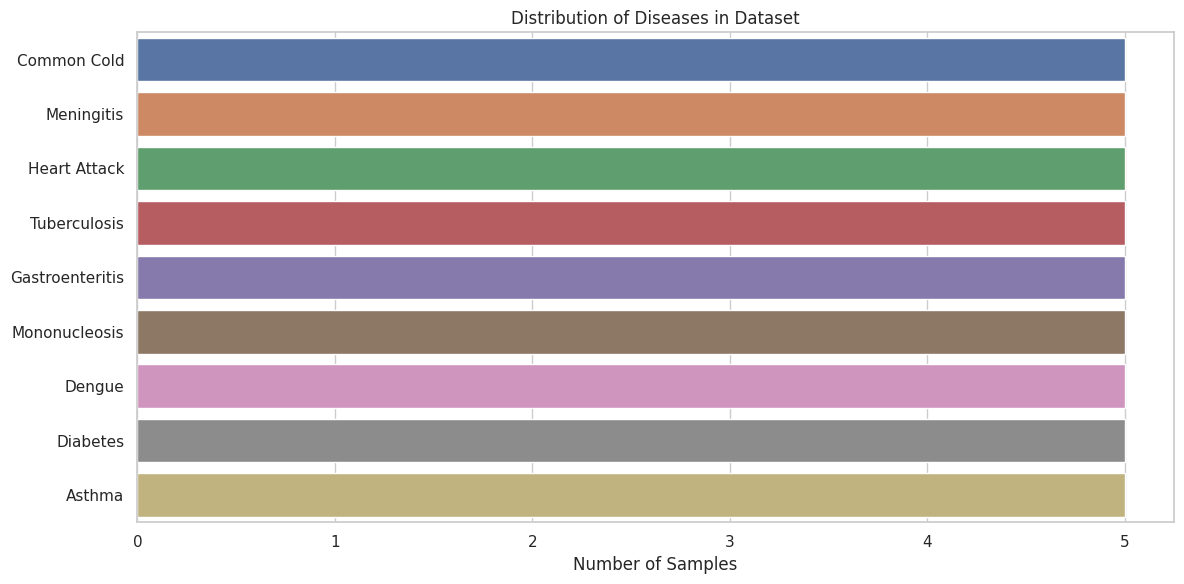


=== Feature Extraction ===
Converting text to TF-IDF features...
✓ Created 72 features

=== Training Naive Bayes Model ===
✓ Naive Bayes Accuracy: 88.89%


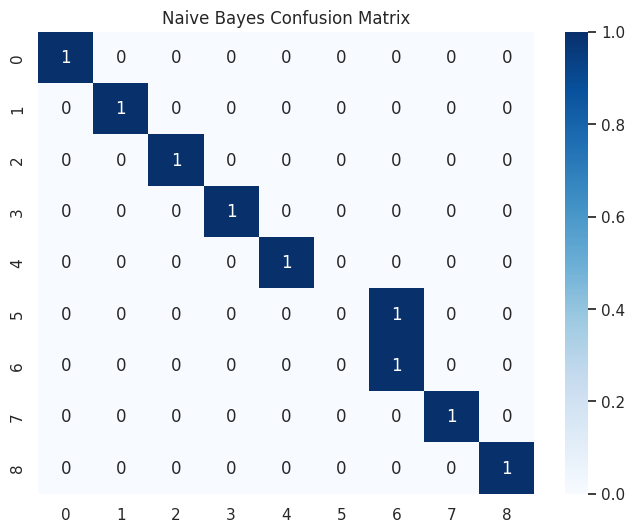


=== Training Random Forest Model ===
Training with 50 trees...
✓ Random Forest Accuracy: 55.56%


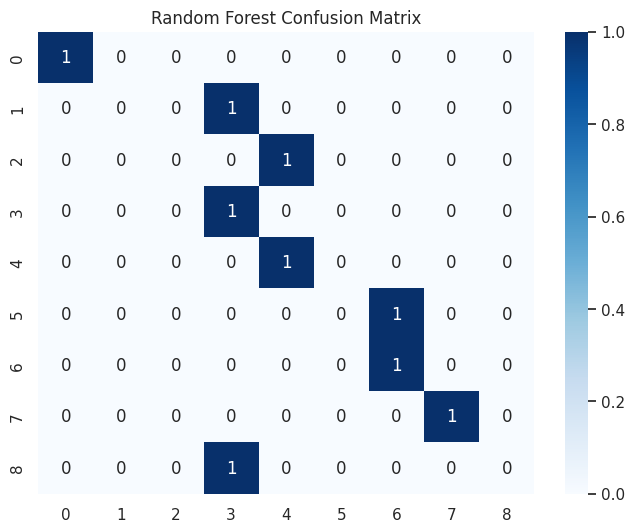


=== Training Deep Learning Model ===
Building neural network...
Training for 30 epochs...
Epoch 1/50
7/7 [==============================] - 1s 64ms/step - loss: 2.1981 - accuracy: 0.1429 - val_loss: 2.2159 - val_accuracy: 0.1250
Epoch 2/50
7/7 [==============================] - 0s 14ms/step - loss: 2.1875 - accuracy: 0.1071 - val_loss: 2.2143 - val_accuracy: 0.1250
Epoch 3/50
7/7 [==============================] - 0s 16ms/step - loss: 2.1832 - accuracy: 0.0714 - val_loss: 2.2128 - val_accuracy: 0.1250
Epoch 4/50
7/7 [==============================] - 0s 13ms/step - loss: 2.1785 - accuracy: 0.1429 - val_loss: 2.2125 - val_accuracy: 0.1250
Epoch 5/50
7/7 [==============================] - 0s 13ms/step - loss: 2.1798 - accuracy: 0.0714 - val_loss: 2.2106 - val_accuracy: 0.1250
Epoch 6/50
7/7 [==============================] - 0s 13ms/step - loss: 2.1637 - accuracy: 0.1786 - val_loss: 2.2083 - val_accuracy: 0.1250
Epoch 7/50
7/7 [==============================] - 0s 12ms/step - loss: 2.14

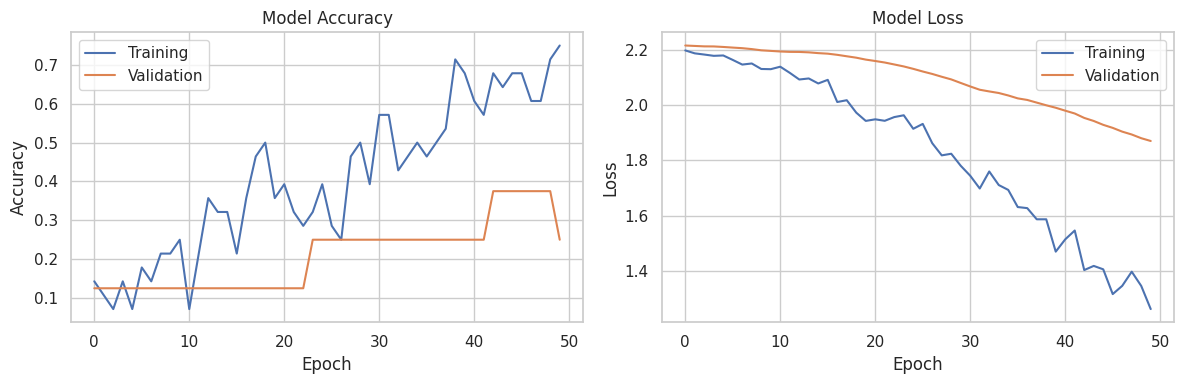

1/1 [==============================] - 0s 129ms/step
✓ Deep Learning Accuracy: 55.56%


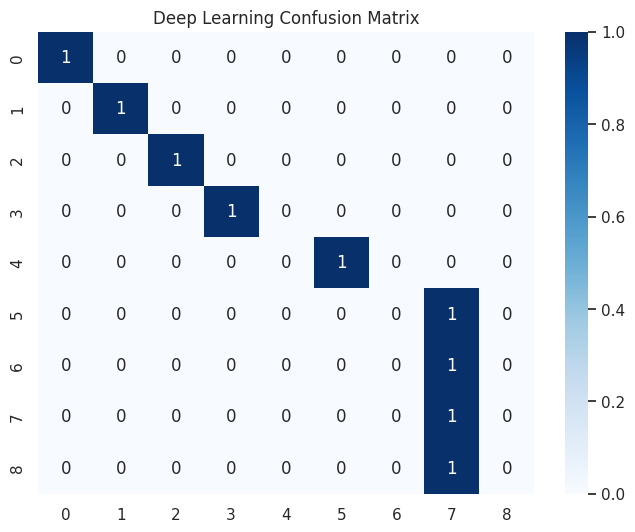


=== Model Comparison ===


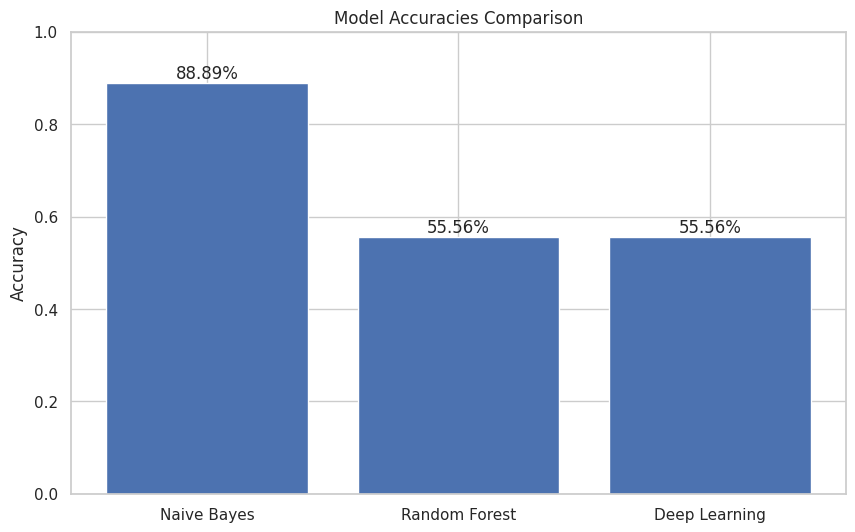

In [43]:
# Initialize models globally for reuse
global GLOBAL_VECTORIZER, GLOBAL_NB_MODEL, GLOBAL_RF_MODEL, GLOBAL_DL_MODEL, GLOBAL_LABEL_ENCODER
GLOBAL_VECTORIZER, GLOBAL_NB_MODEL, GLOBAL_RF_MODEL, GLOBAL_DL_MODEL, GLOBAL_LABEL_ENCODER = train_models(show_progress=True)

### Example: Analyzing Cold Symptoms
Analyze symptoms of a common cold.


=== Prediction Process ===
Input symptoms: fever headache cough runny nose
Processed symptoms: fever headache cough runny nose

Extracted features:
  - nose: 0.5637
  - runny: 0.5637
  - cough: 0.4318
  - headache: 0.3473
  - fever: 0.2398

Using Random Forest model for prediction...

===== SYMPTOM ANALYSIS RESULTS =====
Input symptoms: fever headache cough runny nose
Processed symptoms: fever headache cough runny nose
Model used: Random Forest

Predicted Disease: Common Cold

Top 3 Possible Diseases:
- Common Cold: 32.25% (Low confidence)
- Dengue: 14.31% (Low confidence)
- Tuberculosis: 10.61% (Low confidence)


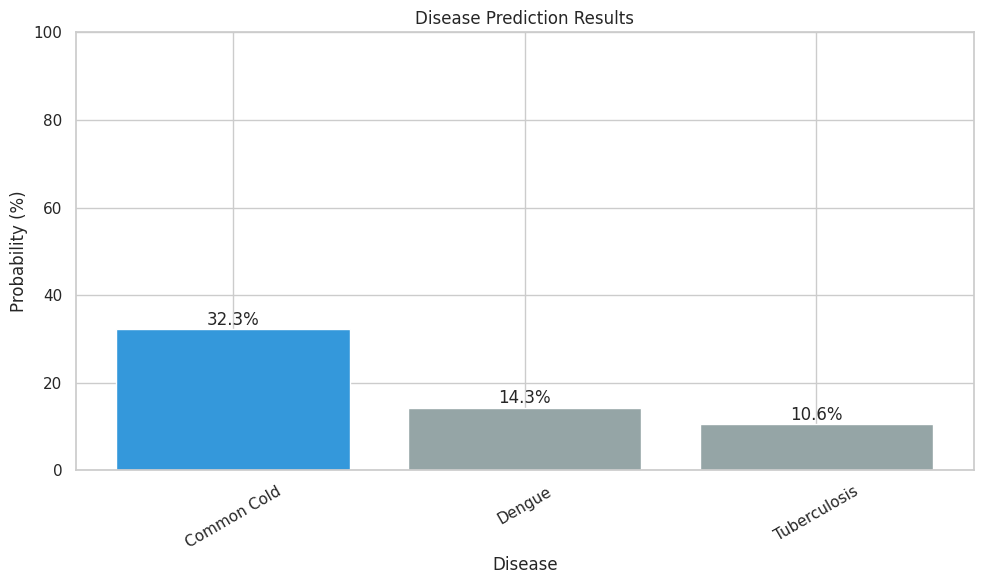


To try a different prediction model, call this function with model_type='nb', 'rf', or 'dl'
Example: analyze_symptoms('fever headache cough', model_type='nb')


{'predicted_disease': 'Common Cold',
 'top_diseases': [('Common Cold', 0.3225129892467355),
  ('Dengue', 0.14310512174444062),
  ('Tuberculosis', 0.10606951820109715)],
 'input_symptoms': 'fever headache cough runny nose',
 'processed_symptoms': 'fever headache cough runny nose',
 'model_used': 'Random Forest'}

In [44]:
# Analyze common cold symptoms
symptoms = "fever headache cough runny nose"
analyze_symptoms(symptoms, model_type='rf', show_training=True)

### Example: Analyzing Heart Attack Symptoms
Analyze symptoms of a heart attack.


=== Prediction Process ===
Input symptoms: chest pain shortness of breath pain in arm sweating
Processed symptoms: chest pain shortness breath pain arm sweating

Extracted features:
  - pain: 0.6106
  - sweating: 0.4956
  - breath: 0.3797
  - shortness: 0.3797
  - chest: 0.3053

Using Naive Bayes model for prediction...

===== SYMPTOM ANALYSIS RESULTS =====
Input symptoms: chest pain shortness of breath pain in arm sweating
Processed symptoms: chest pain shortness breath pain arm sweating
Model used: Naive Bayes

Predicted Disease: Heart Attack

Top 3 Possible Diseases:
- Heart Attack: 33.92% (Low confidence)
- Asthma: 14.29% (Low confidence)
- Tuberculosis: 11.89% (Low confidence)


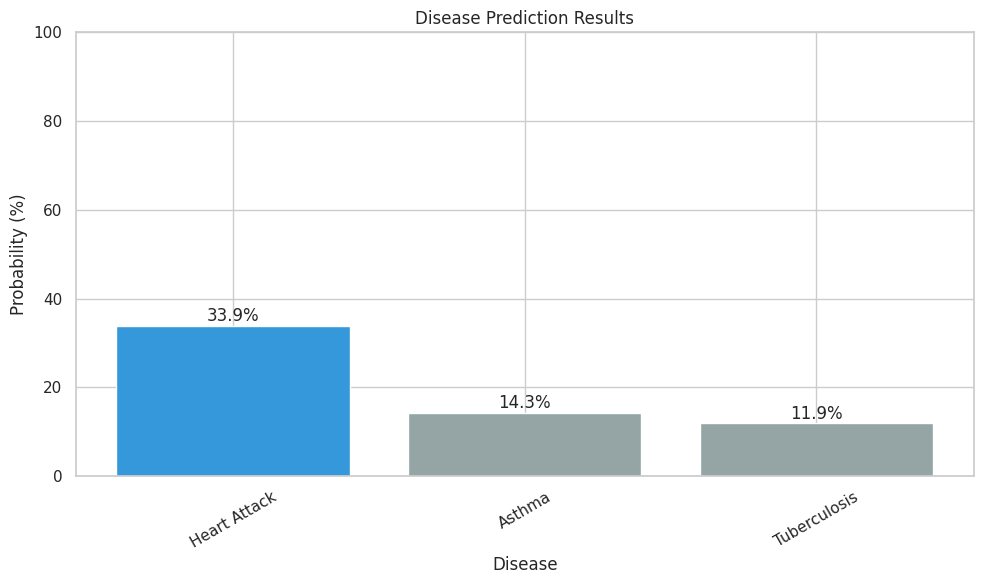


To try a different prediction model, call this function with model_type='nb', 'rf', or 'dl'
Example: analyze_symptoms('fever headache cough', model_type='nb')


{'predicted_disease': 'Heart Attack',
 'top_diseases': [('Heart Attack', 0.3392184277074351),
  ('Asthma', 0.14291936514333262),
  ('Tuberculosis', 0.1189063481465984)],
 'input_symptoms': 'chest pain shortness of breath pain in arm sweating',
 'processed_symptoms': 'chest pain shortness breath pain arm sweating',
 'model_used': 'Naive Bayes'}

In [45]:
# Analyze heart attack symptoms
symptoms = "chest pain shortness of breath pain in arm sweating"
analyze_symptoms(symptoms, model_type='nb', show_training=True)

### Try it yourself!
Enter your own symptoms and analyze them.


=== Prediction Process ===
Input symptoms: cold and cough headache fever
Processed symptoms: cold cough headache fever

Extracted features:
  - cold: 0.6824
  - cough: 0.5228
  - headache: 0.4204
  - fever: 0.2903

Using Random Forest model for prediction...

===== SYMPTOM ANALYSIS RESULTS =====
Input symptoms: cold and cough headache fever
Processed symptoms: cold cough headache fever
Model used: Random Forest

Predicted Disease: Common Cold

Top 3 Possible Diseases:
- Common Cold: 36.63% (Low confidence)
- Meningitis: 14.49% (Low confidence)
- Dengue: 10.55% (Low confidence)


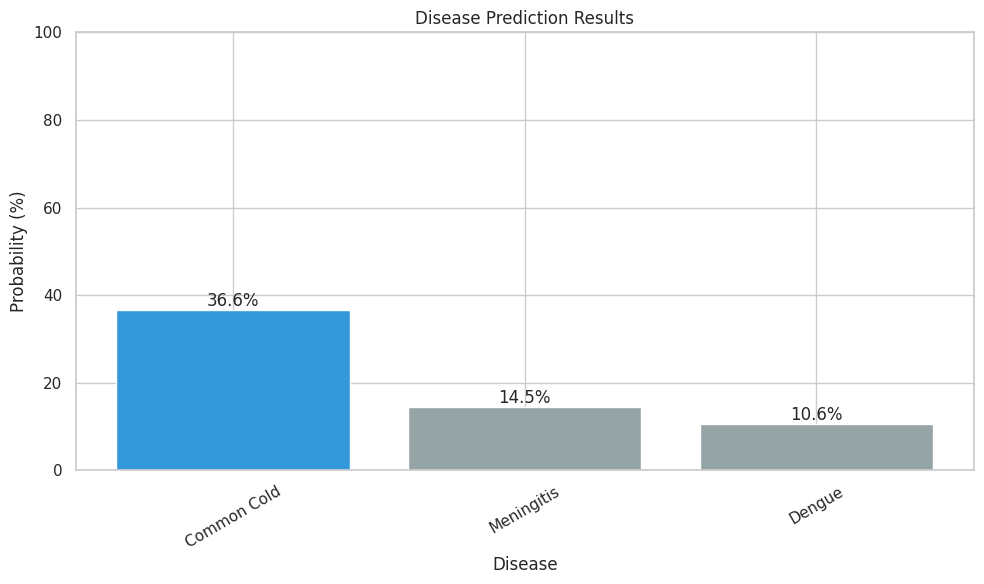


To try a different prediction model, call this function with model_type='nb', 'rf', or 'dl'
Example: analyze_symptoms('fever headache cough', model_type='nb')


In [49]:
# Enter your symptoms below
symptoms = "cold and cough headache fever" # Enter your symptoms here
# Choose model type: 'rf' (Random Forest), 'nb' (Naive Bayes), 'dl' (Deep Learning)
model_type = 'rf'

# Analyze the symptoms
if symptoms:  # Only run if symptoms are provided
    analyze_symptoms(symptoms, model_type=model_type, show_training=True)
else:
    print("Please enter your symptoms in the 'symptoms' variable above.")

### Run the complete demonstration
Run the full demonstration with examples.

In [ ]:
# Run the complete demonstration
notebook_example()